In [2]:
 !pip install torch torchvision captum matplotlib opencv-python ultralytics shap grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 57.3 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00:00:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 31.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 22.8 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 24.9

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import os
from captum.attr import GuidedBackprop, IntegratedGradients, Occlusion
from captum.attr import visualization as viz
import shap
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from ultralytics import YOLO


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [5]:
model_path = '/kaggle/input/modelll/best.pt'
model = YOLO(model_path)

Using sample image from: /kaggle/input/glasss/62d7f647113d262d7f647113d9_frame34_jpg.rf.db61846227bbbd47a9c16c8a94a33c62.jpg


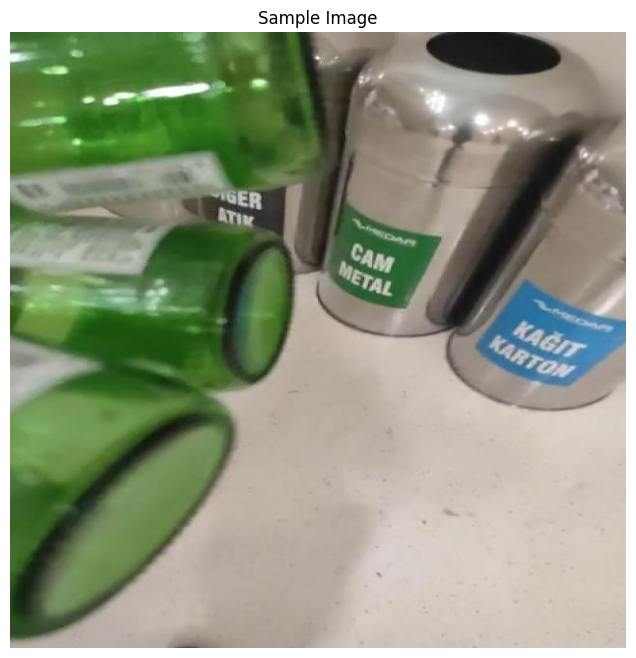

In [8]:
image_path = "/kaggle/input/glasss/62d7f647113d262d7f647113d9_frame34_jpg.rf.db61846227bbbd47a9c16c8a94a33c62.jpg"
if not os.path.exists(image_path):
    print(f"Warning: Image not found at {image_path}")
    print("Please verify the Kaggle path is correct or copy the image to the current directory")
else:
    print(f"Using sample image from: {image_path}")
try:
    img = cv2.imread(image_path)
    if img is None:
        raise Exception("Image could not be read")
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 8))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title("Sample Image")
    plt.show()
except Exception as e:
    print(f"Error loading image: {e}")
    print("Please check that the image exists and is in a supported format")


image 1/1 /kaggle/input/glasss/62d7f647113d262d7f647113d9_frame34_jpg.rf.db61846227bbbd47a9c16c8a94a33c62.jpg: 512x512 1 glass, 256.1ms
Speed: 13.2ms preprocess, 256.1ms inference, 21.1ms postprocess per image at shape (1, 3, 512, 512)


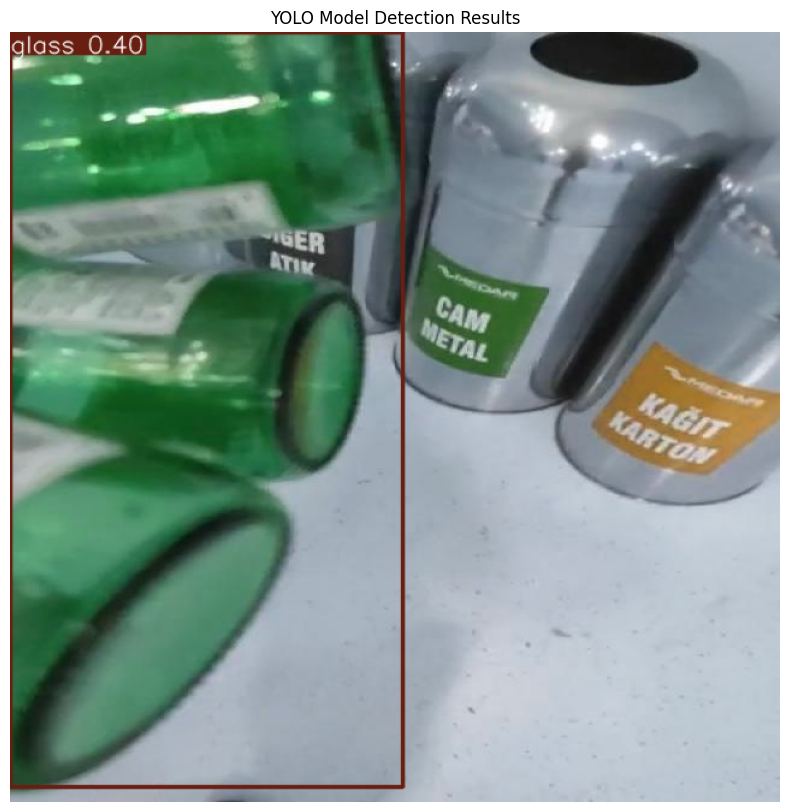

Number of detections: 1
Detection 1: Class = glass, Confidence = 0.4013, Bbox = [0.336456298828125, 0.5019760131835938, 326.5816345214844, 627.3826293945312]


In [9]:
results = model(image_path)

#  results
fig = plt.figure(figsize=(12, 10))
plt.imshow(results[0].plot())
plt.axis('off')
plt.title('YOLO Model Detection Results')
plt.show()

#  prediction details
boxes = results[0].boxes
print(f"Number of detections: {len(boxes)}")
for i, box in enumerate(boxes):
    class_id = int(box.cls.item())
    class_name = results[0].names[class_id]
    confidence = box.conf.item()
    coordinates = box.xyxy.tolist()[0]  # Convert to list for readability
    print(f"Detection {i+1}: Class = {class_name}, Confidence = {confidence:.4f}, Bbox = {coordinates}")

In [11]:
try:
    torch_model = model.model
    print("Successfully accessed the PyTorch model")
    
    print("\nModel Architecture Summary:")
    for name, layer in torch_model.named_modules():
        if len(name) > 0 and not name.startswith('_') and '.' not in name:
            print(f"{name}: {layer.__class__.__name__}")
except Exception as e:
    print(f"Error accessing the PyTorch model: {e}")
    print("Some XAI techniques may not work without direct access to the PyTorch model layers.")

Successfully accessed the PyTorch model

Model Architecture Summary:
model: Sequential


In [12]:
def apply_gradcam_to_yolo(img_path, model, target_layer_name="model.model.model.23"):
    """
    Apply GradCAM to YOLOv5 model
    target_layer_name typically points to the final convolutional layer
    """
    try:
        
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_normalized = img_rgb / 255.0
        result = model(img_path)
        torch_model = model.model
        target_layer = None
        for name, module in torch_model.named_modules():
            if target_layer_name in name:
                target_layer = module
                break
        
        if target_layer is None:
            print(f"Target layer {target_layer_name} not found.")
            print("Available layers:")
            for name, _ in torch_model.named_modules():
                if len(name) > 0:
                    print(name)
            return None
        
        cam = GradCAM(model=torch_model, target_layers=[target_layer], use_cuda=torch.cuda.is_available())
        grayscale_cam = cam(input_tensor=torch.from_numpy(img_normalized).permute(2, 0, 1).unsqueeze(0).float())
        grayscale_cam = grayscale_cam[0]
        cam_image = show_cam_on_image(img_normalized, grayscale_cam, use_rgb=True)
        
        return {
            "original_image": img_rgb,
            "cam_image": cam_image,
            "grayscale_cam": grayscale_cam
        }
    except Exception as e:
        print(f"Error in GradCAM: {e}")
        return None

try:
    gradcam_results = apply_gradcam_to_yolo(image_path, model)
    
    if gradcam_results:
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.imshow(gradcam_results["original_image"])
        plt.title("Original Image")
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(gradcam_results["cam_image"])
        plt.title("GradCAM Heatmap")
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.imshow(gradcam_results["grayscale_cam"], cmap='jet')
        plt.title("GradCAM Attention Map")
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
except Exception as e:
    print(f"Error applying GradCAM: {e}")
    print("GradCAM may require modifications for this specific model architecture.")



image 1/1 /kaggle/input/glasss/62d7f647113d262d7f647113d9_frame34_jpg.rf.db61846227bbbd47a9c16c8a94a33c62.jpg: 512x512 1 glass, 107.6ms
Speed: 2.5ms preprocess, 107.6ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 512)
Target layer model.model.model.23 not found.
Available layers:
model
model.0
model.0.conv
model.0.act
model.1
model.1.conv
model.2
model.2.cv1
model.2.cv1.conv
model.2.cv2
model.2.cv2.conv
model.2.m
model.2.m.0
model.2.m.0.cv1
model.2.m.0.cv1.conv
model.2.m.0.cv2
model.2.m.0.cv2.conv
model.3
model.3.conv
model.4
model.4.cv1
model.4.cv1.conv
model.4.cv2
model.4.cv2.conv
model.4.m
model.4.m.0
model.4.m.0.cv1
model.4.m.0.cv1.conv
model.4.m.0.cv2
model.4.m.0.cv2.conv
model.4.m.1
model.4.m.1.cv1
model.4.m.1.cv1.conv
model.4.m.1.cv2
model.4.m.1.cv2.conv
model.5
model.5.conv
model.6
model.6.cv1
model.6.cv1.conv
model.6.cv2
model.6.cv2.conv
model.6.m
model.6.m.0
model.6.m.0.cv1
model.6.m.0.cv1.conv
model.6.m.0.cv2
model.6.m.0.cv2.conv
model.6.m.1
model.6.m.1.cv1


Note: Occlusion sensitivity analysis may take several minutes to complete depending on image size.
Set window_size smaller and/or stride larger to speed up the process.

image 1/1 /kaggle/input/glasss/62d7f647113d262d7f647113d9_frame34_jpg.rf.db61846227bbbd47a9c16c8a94a33c62.jpg: 512x512 1 glass, 102.0ms
Speed: 2.8ms preprocess, 102.0ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 512)
Analyzing occlusion sensitivity for: glass (confidence: 0.4013)

image 1/1 /kaggle/working/temp_occluded.jpg: 512x512 1 glass, 99.8ms
Speed: 2.3ms preprocess, 99.8ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 512)

image 1/1 /kaggle/working/temp_occluded.jpg: 512x512 1 glass, 98.5ms
Speed: 3.0ms preprocess, 98.5ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 512)

image 1/1 /kaggle/working/temp_occluded.jpg: 512x512 1 glass, 96.4ms
Speed: 2.3ms preprocess, 96.4ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 512)

image 1/1 /kaggle/working/temp

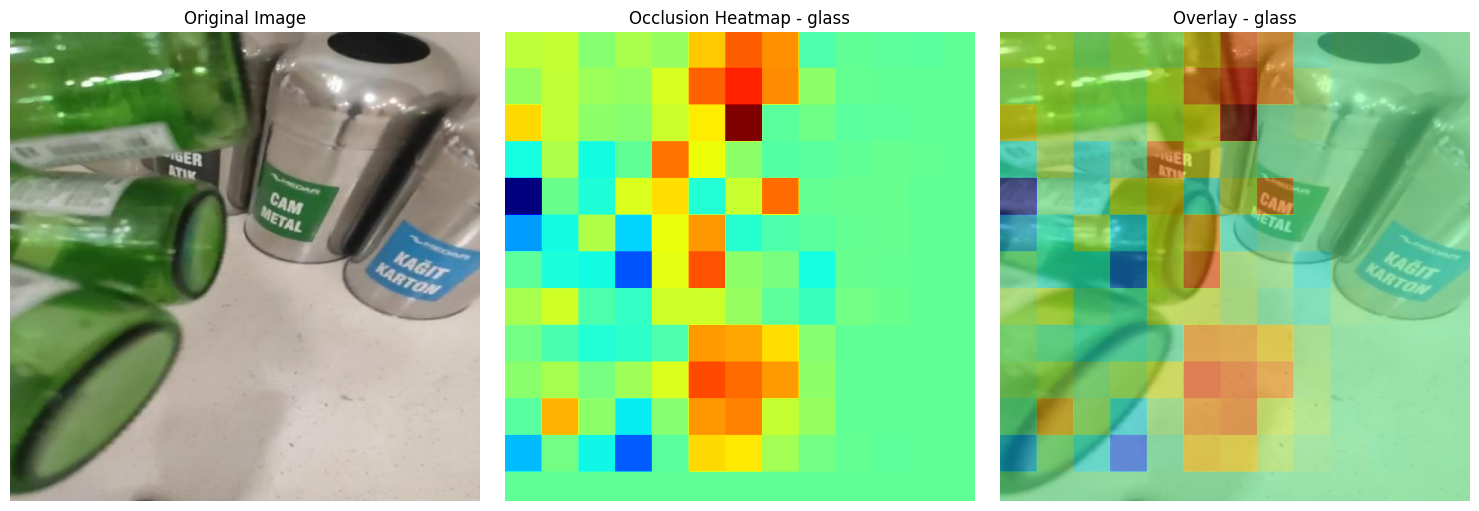

In [14]:
def occlusion_sensitivity(img_path, model, window_size=50, stride=25):
    """
    Apply occlusion sensitivity analysis to identify important regions
    """
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    height, width = img.shape[:2]
    
    original_result = model(img_path)
    original_boxes = original_result[0].boxes
    
    if len(original_boxes) == 0:
        print("No detections in the original image. Occlusion analysis may not be meaningful.")
        return None
    

    heatmap = np.zeros((height, width), dtype=np.float32)
    target_class_id = int(original_boxes[0].cls.item())
    target_class_name = original_result[0].names[target_class_id]
    target_conf = original_boxes[0].conf.item()
    
    print(f"Analyzing occlusion sensitivity for: {target_class_name} (confidence: {target_conf:.4f})")

    for y in range(0, height - window_size, stride):
        for x in range(0, width - window_size, stride):
            occluded_img = img_rgb.copy()
            occluded_img[y:y+window_size, x:x+window_size, :] = 128
 
            temp_path = "temp_occluded.jpg"
            plt.imsave(temp_path, occluded_img)
            result = model(temp_path)
            boxes = result[0].boxes
            found = False
            for box in boxes:
                if int(box.cls.item()) == target_class_id:
                    new_conf = box.conf.item()
                    conf_change = target_conf - new_conf
                    heatmap[y:y+window_size, x:x+window_size] += conf_change
                    found = True
                    break

            if not found:
                heatmap[y:y+window_size, x:x+window_size] += target_conf
                
    if os.path.exists(temp_path):
        os.remove(temp_path)
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)
    
    return {
        "original_image": img_rgb,
        "heatmap": heatmap,
        "class_name": target_class_name
    }

print("Note: Occlusion sensitivity analysis may take several minutes to complete depending on image size.")
print("Set window_size smaller and/or stride larger to speed up the process.")


occlusion_results = occlusion_sensitivity(image_path, model, window_size=50, stride=50)

if occlusion_results:
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(occlusion_results["original_image"])
    plt.title("Original Image")
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(occlusion_results["heatmap"], cmap='jet')
    plt.title(f"Occlusion Heatmap - {occlusion_results['class_name']}")
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(occlusion_results["original_image"])
    plt.imshow(occlusion_results["heatmap"], cmap='jet', alpha=0.5)
    plt.title(f"Overlay - {occlusion_results['class_name']}")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()



SHAP analysis is complex for object detection models.
Consider using one of these alternatives:
1. Feature Importance Analysis in Cell 11
2. Simple Occlusion Importance (uncomment below)

To run the SHAP analysis anyway, uncomment the SHAP code:

Running simple occlusion importance analysis...

image 1/1 /kaggle/input/glasss/62d7f647113d262d7f647113d9_frame34_jpg.rf.db61846227bbbd47a9c16c8a94a33c62.jpg: 512x512 1 glass, 104.2ms
Speed: 2.6ms preprocess, 104.2ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 512)

image 1/1 /kaggle/working/temp_occlusion.jpg: 512x512 1 glass, 102.7ms
Speed: 2.3ms preprocess, 102.7ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 512)

image 1/1 /kaggle/working/temp_occlusion.jpg: 512x512 1 glass, 101.5ms
Speed: 2.2ms preprocess, 101.5ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 512)

image 1/1 /kaggle/working/temp_occlusion.jpg: 512x512 1 glass, 103.7ms
Speed: 2.6ms preprocess, 103.7ms inference, 1.3ms postpro

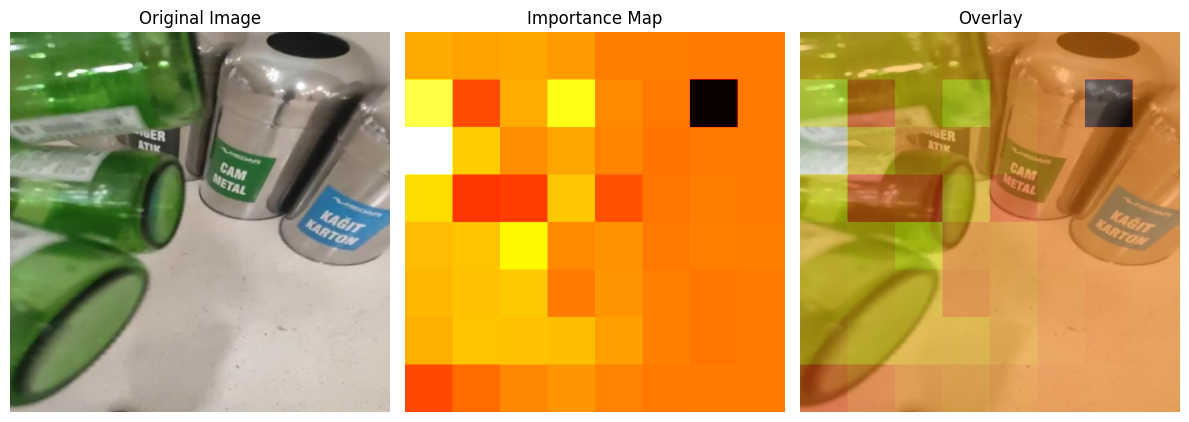

In [23]:
def simple_occlusion_importance(img_path, model, grid_size=16):
    """
    A simple alternative to SHAP using occlusion sensitivity
    """
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img_rgb.shape[:2]
    orig_result = model(img_path)
    orig_boxes = orig_result[0].boxes
    
    if len(orig_boxes) == 0:
        print("No detections found in the original image")
        return None
    baseline_conf = orig_boxes[0].conf.item()
    importance = np.zeros((h, w), dtype=np.float32)
    cell_h = h // grid_size
    cell_w = w // grid_size

    for i in range(grid_size):
        for j in range(grid_size):
            y1, y2 = i * cell_h, (i + 1) * cell_h
            x1, x2 = j * cell_w, (j + 1) * cell_w
            occluded = img_rgb.copy()
            occluded[y1:y2, x1:x2, :] = 0  
            temp_path = "temp_occlusion.jpg"
            plt.imsave(temp_path, occluded)
            result = model(temp_path)
            if len(result[0].boxes) > 0:
                new_conf = result[0].boxes[0].conf.item()
                impact = baseline_conf - new_conf
            else:
                impact = baseline_conf  
                
            
            importance[y1:y2, x1:x2] = impact
            
        
            if os.path.exists(temp_path):
                os.remove(temp_path)
    if importance.max() > 0:
        importance = importance / importance.max()
    
    return {
        "original_image": img_rgb,
        "importance_map": importance
    }


print("\nSHAP analysis is complex for object detection models.")
print("Consider using one of these alternatives:")
print("1. Feature Importance Analysis in Cell 11")
print("2. Simple Occlusion Importance (uncomment below)")
print("\nTo run the SHAP analysis anyway, uncomment the SHAP code:")
print("\nRunning simple occlusion importance analysis...")
occlusion_importance = simple_occlusion_importance(image_path, model, grid_size=8)

if occlusion_importance:
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(occlusion_importance["original_image"])
    plt.title("Original Image")
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(occlusion_importance["importance_map"], cmap='hot')
    plt.title("Importance Map")
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(occlusion_importance["original_image"])
    plt.imshow(occlusion_importance["importance_map"], cmap='hot', alpha=0.5)
    plt.title("Overlay")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()






image 1/1 /kaggle/working/temp_original.jpg: 512x512 1 glass, 100.8ms
Speed: 2.3ms preprocess, 100.8ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 512)

image 1/1 /kaggle/working/temp_gray.jpg: 512x512 2 glasss, 100.9ms
Speed: 2.5ms preprocess, 100.9ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 512)

image 1/1 /kaggle/working/temp_blur.jpg: 512x512 1 glass, 100.4ms
Speed: 2.5ms preprocess, 100.4ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 512)

image 1/1 /kaggle/working/temp_edges.jpg: 512x512 (no detections), 101.9ms
Speed: 2.5ms preprocess, 101.9ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 512)


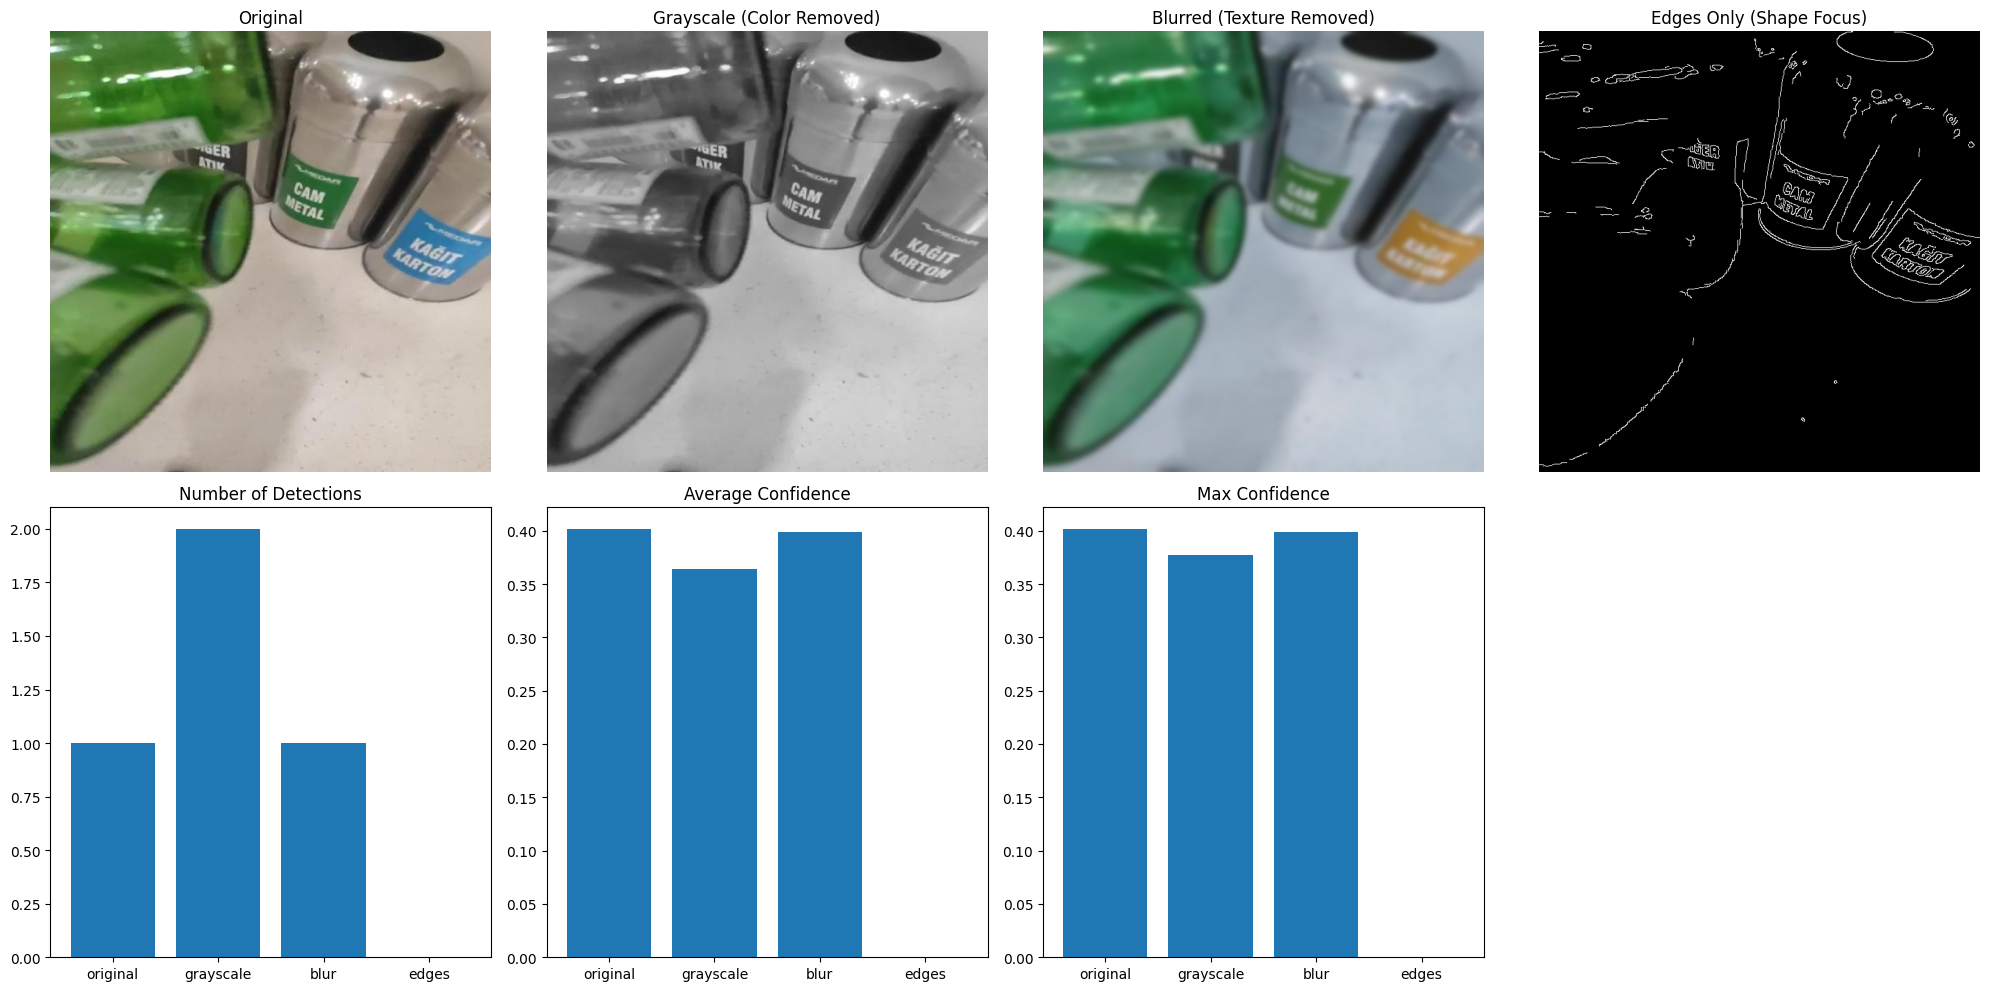

In [22]:
def analyze_feature_importance(img_path, model):
    """
    Analyze which features (colors, textures, shapes) contribute most to predictions
    """
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_gray_rgb = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2RGB)  #
s
    img_blur = cv2.GaussianBlur(img, (21, 21), 0)

    img_edges = cv2.Canny(img, 100, 200)
    img_edges_rgb = cv2.cvtColor(img_edges, cv2.COLOR_GRAY2RGB)
    ly
    temp_paths = {
        "original": "temp_original.jpg",
        "grayscale": "temp_gray.jpg",
        "blur": "temp_blur.jpg",
        "edges": "temp_edges.jpg"
    }
    
    cv2.imwrite(temp_paths["original"], cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR))
    cv2.imwrite(temp_paths["grayscale"], cv2.cvtColor(img_gray_rgb, cv2.COLOR_RGB2BGR))
    cv2.imwrite(temp_paths["blur"], cv2.cvtColor(img_blur, cv2.COLOR_RGB2BGR))
    cv2.imwrite(temp_paths["edges"], img_edges_rgb)
    

    results = {}
    for name, path in temp_paths.items():
        result = model(path)
        results[name] = result
    

    summary = {}
    for name, result in results.items():
        boxes = result[0].boxes
        if len(boxes) > 0:
            detections = len(boxes)
            avg_conf = sum([box.conf.item() for box in boxes]) / detections
            max_conf = max([box.conf.item() for box in boxes])
        else:
            detections = 0
            avg_conf = 0
            max_conf = 0
            
        summary[name] = {
            "detections": detections,
            "avg_confidence": avg_conf,
            "max_confidence": max_conf
        }
    

    for path in temp_paths.values():
        if os.path.exists(path):
            os.remove(path)

    return {
        "summary": summary,
        "images": {
            "original": img_rgb,
            "grayscale": img_gray_rgb,
            "blur": img_blur,
            "edges": img_edges_rgb
        }
    }


feature_importance = analyze_feature_importance(image_path, model)

plt.figure(figsize=(20, 10))

plt.subplot(2, 4, 1)
plt.imshow(feature_importance["images"]["original"])
plt.title("Original")
plt.axis('off')

plt.subplot(2, 4, 2)
plt.imshow(feature_importance["images"]["grayscale"])
plt.title("Grayscale (Color Removed)")
plt.axis('off')

plt.subplot(2, 4, 3)
plt.imshow(feature_importance["images"]["blur"])
plt.title("Blurred (Texture Removed)")
plt.axis('off')

plt.subplot(2, 4, 4)
plt.imshow(feature_importance["images"]["edges"], cmap='gray')
plt.title("Edges Only (Shape Focus)")
plt.axis('off')

# Display summary statistics
plt.subplot(2, 4, 5)
names = list(feature_importance["summary"].keys())
detections = [feature_importance["summary"][name]["detections"] for name in names]
plt.bar(names, detections)
plt.title("Number of Detections")

plt.subplot(2, 4, 6)
avg_conf = [feature_importance["summary"][name]["avg_confidence"] for name in names]
plt.bar(names, avg_conf)
plt.title("Average Confidence")

plt.subplot(2, 4, 7)
max_conf = [feature_importance["summary"][name]["max_confidence"] for name in names]
plt.bar(names, max_conf)
plt.title("Max Confidence")

plt.tight_layout()
plt.show()